In [126]:
## PARTIE 1: IMPLEMENTATION DE L'ESTIMATION CONTINUE DE LA VRAISEMBLANCE A L'AIDE D'UN FILTRE PARTICULAIRE

import numpy as np
import scipy.stats
from scipy.stats import uniform
import scipy.optimize
from scipy.optimize import minimize
import math
import sympy
from sympy import DiracDelta
import matplotlib.pyplot as plt
import random

## Implementation du filtre a particule pour les SV-GARCH

def compute_h_t_plus_1(h_t, mu, phi, sigma, rho, y):
    e_t = y*np.exp(-h_t/2)
    h_t_plus_1 = mu*(1-phi)+phi*h_t+sigma*rho*e_t + sigma*np.sqrt(1-rho**2)

def initial_values(y, v, M, L, gamma, alpha, beta, phi): ## l est le lag choisit tel qu'indique dans l'article
    v_L = [v[L] for k in range(M)]
    for lag in range(L):
        for i in range(M):
            v_L[i] = (v_L[i]-gamma)/(alpha + beta*(phi*np.random.normal(0, 1, size = 1) + np.sqrt(1-phi**2)*np.random.normal(0, 1, size = 1))**2)
    v_0 = v[L]
    return v_0

for i in range(M):
    eps = y[i]*np.exp(h[i]/2)
    h[i] = mu*(1-phi)+phi*h[i]+sigma*rho*eps+sigma*np.sqrt(1-rho**2)            
    
def particle_filtering(y, v, M, L, gamma, alpha, beta, phi): #y is an array of observed data, v is an array of simulated particles, M is the FP sample size
    v_sim = [[0 for k in range(M)] for m in range(len(y))]
    v_f = v_sim
    w = [[0 for k in range(M)] for m in range(len(y))] 
    l = [[0 for k in range(M)] for m in range(len(y))] # stocke les poids lambda de chaque simulation
    ## on chope d'abord M valeurs v_0
    v_0 = initial_values(y, v, M, L, gamma, alpha, beta, phi)
    v_sim[0] = v_0
    ## on execute la partie iterative de l'algorithme
    for t in range(1,len(y)):
        
        for i in range(M):
            v_sim[t][i] = gamma + alpha*v_sim[t-1][i] + beta*v_sim[t-1][i]*(phi*np.random.normal(0, 1, size = 1) + np.sqrt(1-phi**2)*np.random.normal(0, 1, size = 1))**2 #transitive kernel h_t+1|h_t,y_t
            w[t][i] = (2*np.pi*v_sim[t][i])**(-0.5)*math.exp(-0.5*y[t]/v_sim[t][i]**(0.5))
        for i in range(M):
            l[t][i] = w[t][i]/(sum(w[t]))
        
        #v_sorted = [[0 for k in range(M)] for l in range(len(y))]
        v_sorted[i] = np.sort([v_sim[k][i] for k in range(len(y))])

        def G(x, k, i):
            #return uniform.cdf((x - v_sorted[i][k-1])/(v_sorted[i][k] - v_sorted[i][k-1]))
            return uniform.cdf((x - v_sim[k-1][i])/(v_sim[k][i] - v_sim[k-1][i]))
        def F(x, k):
            return sum([l[k][i]*G(x, k, i) for i in range(M-1)])
        
        for j in range(M-1):
            v_f[t][j] = F(v_sim[t][j], t)
    return v_f

NameError: name 'h' is not defined

In [60]:
def simulate_svgarch(gamma, alpha, beta, T):#alpha + beta < 1
    if alpha+beta>=1:
        raise NameError("Alpha + Beta must be less than 1")
    y = [0 for t in range(T)]
    v = [0 for t in range(T)]
    v[0] = gamma/(1 - alpha - beta)
    for t in range(T-1):
        eps = np.random.normal(0 , 1, size = 1)
        y[t] = np.sqrt(v[t])*eps
        v[t+1] = gamma + alpha*v[t] + beta*y[t]**2
    return y, v

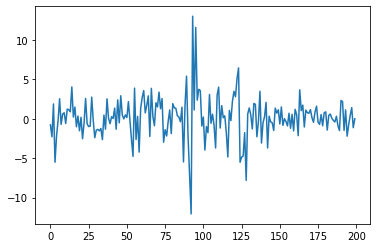

In [62]:
y, v = simulate_svgarch(1,0.3,0.4, 200)
plt.plot(y)

In [41]:
# definition de la log-vraisemblance
M = 100
l = 10

def neg_log_likelihood(theta): # theta = [gamma, alpha, beta, phi]
    filter_data = particle_filtering(y, v, M, l, theta[0], theta[1], theta[2], theta[3])
    list_sum = []
    for i, cur_fil in enumerate(filter_data):
        print(f"We are now at loop {i}")
        cur_sum = sum(cur_fil)
        list_sum.append(cur_sum)
    return -sum(np.log(list_sum))

In [42]:
#calcul du maximum de vraisemblance

x0 = np.array([0.1, 0.1, 0.1, 0.1])
max_vrais = -minimize(neg_log_likelihood, x0, method='Nelder-Mead', tol=1e-6).x

IndexError: index 1 is out of bounds for axis 0 with size 1

In [32]:
## PARTIE 3: TEST SUR DES DONNEES REELLES

In [33]:
max_vrais

array([-0.10187596, -0.09562521, -0.10187417, -0.10187402])

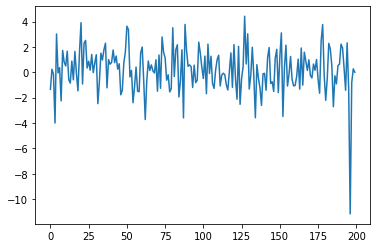

In [160]:
def simulate_svgarch(gamma, alpha, beta, phi,  T): #alpha + beta < 1
    y = [0 for t in range(T)]
    v = [0 for t in range(T)]
    v[0] = gamma/(1 - alpha - beta)
    for t in range(T-1):
        eps = np.random.normal(0 , 1, size = 1)
        xi = np.random.normal(0,1,size=1)
        zeta = phi*eps+np.sqrt(1-phi**2)*xi
        y[t] = np.sqrt(v[t])*eps
        v[t+1] = gamma + alpha*v[t] + beta*v[t]*(zeta)**2
    return y, v
y, v = simulate_svgarch(1,0.3,0.4, 0.01, 200)
plt.plot(y)



In [355]:
import random

def initial_values(y, v, M, L, gamma, alpha, beta, phi): ## l est le lag choisit tel qu'indique dans l'article
    v_L = [v[L] for k in range(M)]
    for lag in range(L):
        for i in range(M):
            v_L[i] = (v_L[i]-gamma)/(alpha + beta*(phi*np.random.normal(0, 1, size = 1) + np.sqrt(1-phi**2)*np.random.normal(0, 1, size = 1))**2)
    v_0 = v[L]
    return v_0

class sv_garch_filtering(object):
    sigma = []
    
    def __init__(self, y, gamma, alpha, beta, phi, M, T, malik=False):
        self.y = y
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.phi = phi
        self.T = T
        self.M = M
        self.V = np.zeros((T,M))
        self.W = np.zeros((T,M))
        self.Lambda = np.zeros((T,M))
        self.t = 0
        self.malik = malik
        self.initial_values()
        
    
    def initial_values(self):
        for i in range(self.M):
            self.V[0,i] = np.random.normal(0,1,size=1)**2
        return self.V[0,:]
    
    def one_cycle(self):
        self.next_v()
        self.update_lambda()
        list_new_V = []
        for i in range(self.M):
            if self.malik:
                new_v = self.roll_malik_pitt()
            else:
                new_v = self.roll_discountinuous()
            list_new_V.append(new_v)
        self.V[self.t+1,:] = np.array(list_new_V)
        self.t+=1
    
    def full_cycle(self):
        for i in range(self.T-1):
            self.one_cycle()
        return self.V
    
    def next_v(self):
        t = self.t
        assert self.t < self.T
        for i in range(self.M):
            eps = self.y[t]/np.sqrt(self.V[t,i])
            xi = np.random.normal(0,1,size=1)
            zeta = self.phi*eps+np.sqrt(1-self.phi**2)*xi
            self.V[t+1,i] = self.gamma + self.alpha*self.V[t,i] + self.beta*self.V[t,i]*(zeta)**2
        
    def update_lambda(self):
        t = self.t
        for i in range(self.M):
            self.W[t+1,i] = ((2*np.pi*self.V[t+1,i])**(-0.5))*np.exp(-0.5*(self.y[t+1]**2)/np.sqrt(self.V[t+1,i]))
        for i in range(self.M):
            self.Lambda[t+1,i] = self.W[t+1,i]/sum(self.W[t+1,:])
    
    def roll_discontinuous(self):
        t = self.t
        number = random.uniform(0, np.sum(self.Lambda[t+1, 1:]))
        current = 0
        for i, bias in enumerate(self.Lambda[t+1, :]):
            current += bias
            if number <= current:
                return self.V[t+1,i]
    
    def roll_malik_pitt(self):
        t = self.t
        v_order = (-self.V[t+1]).argsort()
        v_ordered = self.V[t+1][v_order[::-1]]
        lbd_ordered = self.Lambda[t+1][v_order[::-1]]
        trunkated_weights = [(lbd_ordered[i+1]+lbd_ordered[i])/2 for i in range(0,self.M-1)]
        
        weight = np.append(trunkated_weights, [lbd_ordered[-1]/2])
        # print(v_ordered)
        x=np.random.uniform(v_ordered[0], v_ordered[-1])
        v_ordered = np.append(v_ordered, np.inf)
        tirage = self.tirage_sum(x,v_ordered, lbd_ordered)
        return tirage
    
    def tirage_uniform(self, x, v_ordered, i):
        v_ordered = np.append(v_ordered, np.inf)
        if x<=v_ordered[i+1] and x>=v_ordered[i]:
            return uniform.cdf((x - v_ordered[i])/(v_ordered[i+1] - v_ordered[i]))
        else:
            return 0
        
    def tirage_sum(self, x, v_ordered, lambda_ordered):
        return sum([lambda_ordered[i]*self.tirage_uniform(x, v_ordered, i) for i in range(M)])
    
        

In [356]:
T=200
y, v = simulate_svgarch(gamma=0.01,alpha=0.925,beta=0.069, phi=0.1, T=200)

In [361]:
# definition de la log-vraisemblance
M = 25

def neg_log_likelihood(theta): # theta = [gamma, alpha, beta, phi]
    gamma, alpha, beta, phi = theta[0], theta[1], theta[2], theta[3]
    l = sv_garch_filtering(y, gamma, alpha, beta, phi, M, T, malik=True)
    m = l.full_cycle()
    t = np.sum(m, axis=0)
    return -np.sum(np.log(t))


In [362]:
m = neg_log_likelihood(x0)

In [ ]:
x0 = np.array([0.03, 0.5, 0.01, 0.05])
max_vrais = -minimize(neg_log_likelihood, x0, 
                      method='Nelder-Mead', tol=1e-6).x

In [ ]:
max_vrais

In [244]:
m = np.random.uniform(1,2)

In [245]:
m

1.418799696648462